# detect fake tweet with logistic regression
Description


# Importing library


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
import sklearn as sk #this is the most popular library for statistics and machine learning
import matplotlib.pyplot as plt 
import os
import itertools
import collections
import re
import textstat
import networkx
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import string
from collections import Counter


## Reading data and summarizing

In [2]:
df = pd.read_csv('tweets_labeled.csv', index_col=0)
df.head(10)

,text,label
tweet_id,,
1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0
1175456815674343424,'RT @kcResister: Warren: 'Congress is complici...,1
1180809117310623744,'RT @ShimonPro: A dozen current and former sta...,1
1179840318935576578,'RT @samstein: This is a bombshell that isn’t ...,1
1081722778125062144,'Planned Parenthood Erects Billboards Urging W...,0


## Define Functions and Features

In [3]:

def contains_hashtag(tweet):
    #if a tweet contains a link (has 'http' in it) return 1 (true) otherwise return 0 (false)
    if '#' in tweet:
        return 1
    else:
        return 0


def contains_link(tweet):
    #if a tweet contains a link (has 'http' in it) return 1 (true) otherwise return 0 (false)
    if 'http' in tweet or 't.co' in tweet:
        return 1
    else:
        return 0

def contains_mention(tweet):
    #if a tweet contains a link (has 'http' in it) return 1 (true) otherwise return 0 (false)
    if '@' in tweet:
        return 1
    else:
        return 0



  # Remove emojies from code
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)
          
            
            
            
# remove outlier and extra characters
def clean_word():
    word = df['text'].str.replace(r'RT\s', '')
    word = word.str.replace("}", "")
    word = word.str.replace("{", "")
    word = word.str.replace("-", "")
    word = word.str.replace("--", "")
    word = word.str.replace("|", "")
    word = word.str.replace("¦", "")
    word = word.str.replace(",", "")
    word = word.str.replace(".", "")
    word = word.str.replace(":", "")
    word = word.str.replace("?", "")
    word = word.str.replace("#", "")
    word = word.str.replace("(", "")
    word = word.str.replace(")", "")
    word = word.str.replace("!", "")
    word = word.str.replace(";", "")
    word = word.str.replace("&", "")
    word = word.str.replace("'", "")
    word = word.str.replace('—', "")
    word = word.str.replace("i'm", "i am")
    word = word.str.replace("it's", "it is")
    word = word.str.replace(r'RT\s', '')
    word = word.str.replace(r'@\S*?\s', '')
    word = word.str.replace(r'@\S*?$', '')
    word = word.str.replace(r'https\S*?\s', ' ')  
    word = word.str.replace(r'https\S*?$', '')
    word = word.str.replace('\'', '')
    word = word.str.replace(r'…', '')
    word = word.str.replace(r'\s$', '')
    df['cleaned_text'] = word 
    return word 

stop = stopwords.words('english')

def words_only_count(tweet):
    words = tweet.split()
    words_only = [word for word in words if word not in stop and
              not word.startswith(('#', '@'))]
    return len(words_only)

In [4]:
clean_word()
df['contains_hashtag'] = df['text'].apply(contains_hashtag)
df['contains_mention'] = df['text'].apply(contains_mention)
df['contains_link'] = df['text'].apply(contains_link)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_emoji(x))
df['words_only_count'] = df['cleaned_text'].apply(words_only_count)
df['cleaned_text'] = [entry.lower() for entry in df['cleaned_text']]
df['readability ']=df['cleaned_text'].apply(textstat.flesch_reading_ease)
df.to_csv("tweets_labeled_V2.csv", encoding='utf-8', index=False)

df.head()

,text,label,cleaned_text,contains_hashtag,contains_mention,contains_link,words_only_count,readability
tweet_id,,,,,,,,
1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1,the endangered species act saved the bald eagl...,0,1,0,13,58.62
1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1,interesting concept impeach first find facts ...,0,1,0,16,45.76
1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0,buildthewall deportthemall,1,1,1,2,-91.30
1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0,why would the mexican gov’t fund this who are ...,0,1,1,7,83.66
1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0,sweden announces plan to get 100% of energy fr...,0,1,1,16,55.24


## Data Explore


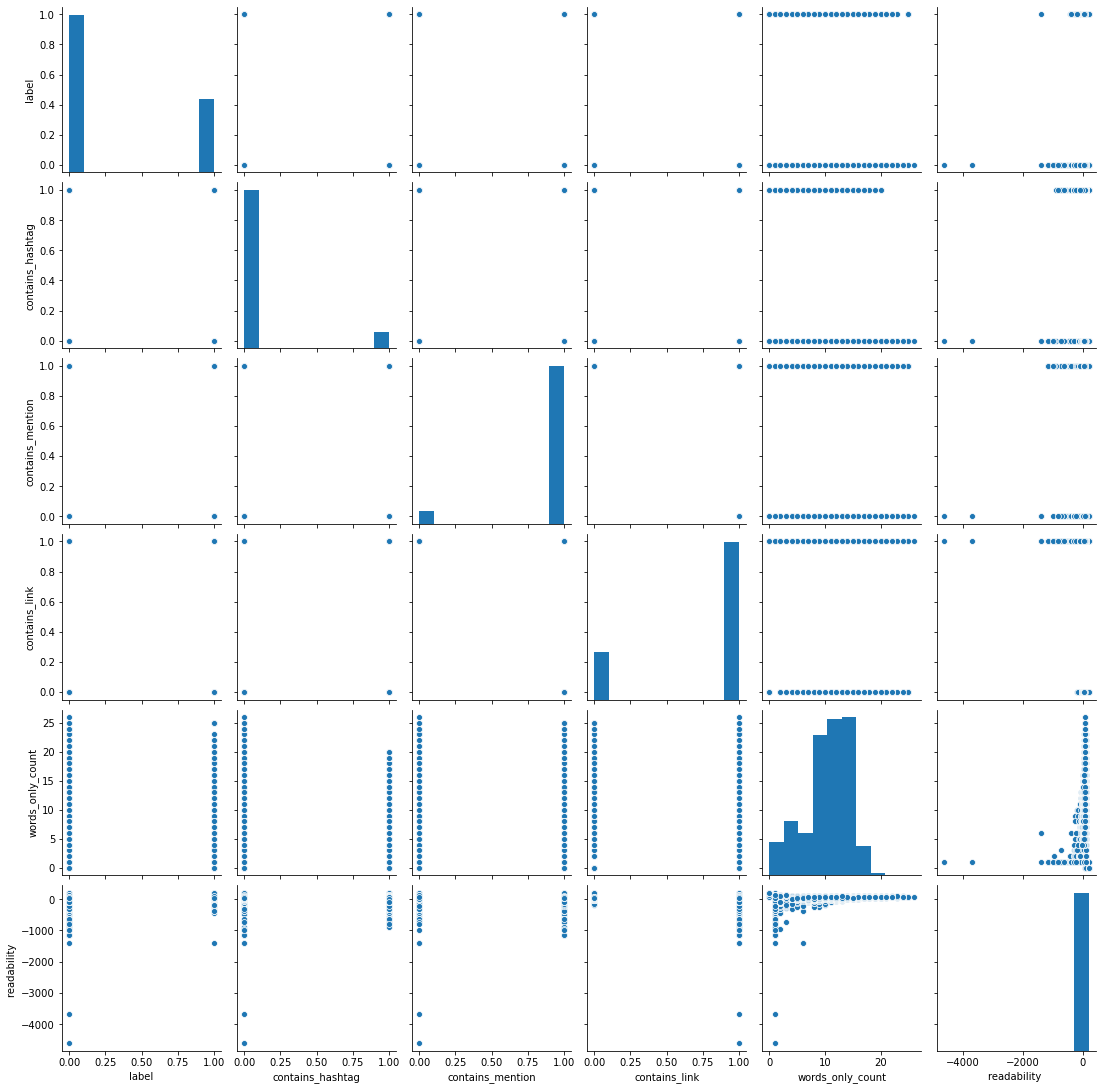

In [5]:
sns.pairplot(df)